In [3]:
from pathlib import Path  
from matplotlib import pyplot as plot
from pathlib import Path  
import pandas as pandas
import numpy as numpy
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")

In [90]:
dataframe = pandas.read_csv("dataset.csv").dropna()
feature_names = ["Appliances","T1","RH_1","T2","RH_2","T3","RH_3","T4","RH_4","T5","RH_5","T6","RH_6","T7","RH_7","T8","RH_8","T9","RH_9","T_out","Press_mm_hg","RH_out","Windspeed","Visibility","Tdewpoint"]
dataframe = dataframe[feature_names]

X = dataframe.drop("Appliances", axis = 1)
y = dataframe["Appliances"]
TEST_SIZE_RATIO = 0.20
RANDOM_STATE_SEED = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE_RATIO, random_state=RANDOM_STATE_SEED)

In [91]:
GBR_metrics_dataset_PATH = Path("./GBR_metrics_dataset.csv")
if not (GBR_metrics_dataset_PATH.exists() and GBR_metrics_dataset_PATH.is_file()):
    N_ESTIMATORS = 10_000
    MAX_DEPTH_SET = [1, 2, 3]
    performance = {}
    for max_depth_iterator in MAX_DEPTH_SET:
        print("\nTraining Gradient Boosted Regression Model for MAX_DEPTH: %d" %max_depth_iterator)
        # Applying Gradient Boosting Regression model to the dataset.
        # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html
        gradient_boosting_regressor = GradientBoostingRegressor(n_estimators = N_ESTIMATORS, max_depth = max_depth_iterator, verbose = 1)
        gradient_boosting_regressor.fit(X_train, y_train)

        # Calculate the metrics for the model.
        # Reference: https://scikit-learn.org/stable/modules/model_evaluation.html
        performance[max_depth_iterator] = {}
        for ilteration, y_pred in enumerate(gradient_boosting_regressor.staged_predict(X)):
            performance[max_depth_iterator][ilteration + 1] = {
                "training_loss": gradient_boosting_regressor.loss_(y, y_pred),
                "root_mean_square_error": mean_squared_error(y, y_pred, squared=False),
                "r2_score": r2_score(y, y_pred),
                "mean_absolute_error": mean_absolute_error(y, y_pred),
                "mean_absolute_percentage_error": mean_absolute_percentage_error(y, y_pred)
            }
    
    # Save the calculated metrics of the Gradient Boosting Regression Model into the csv.
    csv_string = "\"max_depth\",\"iteration\",\"training_loss\",\"root_mean_square_error\",\"r2_score\",\"mean_absolute_error\",\"mean_absolute_percentage_error\""
    for depth in performance.keys():
        for iteration in numpy.arange(1, len(performance[depth]) + 1):
            csv_string = csv_string + "\n" + str(depth) + "," + str(iteration) + "," + str(performance[depth][iteration]["training_loss"]) + "," + str(performance[depth][iteration]["root_mean_square_error"]) + "," + str(performance[depth][iteration]["r2_score"]) + "," + str(performance[depth][iteration]["mean_absolute_error"]) + "," + str(performance[depth][iteration]["mean_absolute_percentage_error"])
    gradient_boosted_graph_metrics_dataset = open(GBR_metrics_dataset_PATH.name, "w")
    gradient_boosted_graph_metrics_dataset.write(csv_string)
    gradient_boosted_graph_metrics_dataset.close()

    # Save the importance of the feature w.r.t the most important feature and store the data into csv.
    # Reference: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor.feature_importances_
    GBR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH = Path("./GBR_releative_feature_importance_dataset.csv")
    feature_importance = gradient_boosting_regressor.feature_importances_
    releative_feature_importance = (feature_importance / feature_importance.max()) * 100
    sorted_indices=numpy.argsort(releative_feature_importance)
    pandas.DataFrame(data = {"feature_names": numpy.array(feature_names)[sorted_indices], "releative_feature_importance": releative_feature_importance[sorted_indices], "feature_importance": feature_importance[sorted_indices]}).to_csv(GBR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH.name)


Training Gradient Boosted Regression Model for MAX_DEPTH: 1
      Iter       Train Loss   Remaining Time 
         1       10344.4417            5.67m
         2       10307.7108            5.60m
         3       10277.0176            5.59m
         4       10249.0463            5.58m
         5       10225.4789            5.57m
         6       10203.5961            5.46m
         7       10184.3245            5.38m
         8       10165.7425            5.32m
         9       10147.7855            5.27m
        10       10129.7352            5.24m
        20        9996.9486            5.05m
        30        9899.1374            4.98m
        40        9819.2932            4.95m
        50        9750.4091            4.92m
        60        9689.0952            4.90m
        70        9632.9461            4.89m
        80        9580.3922            4.87m
        90        9531.5996            4.86m
       100        9485.6303            4.87m
       200        9141.0390           

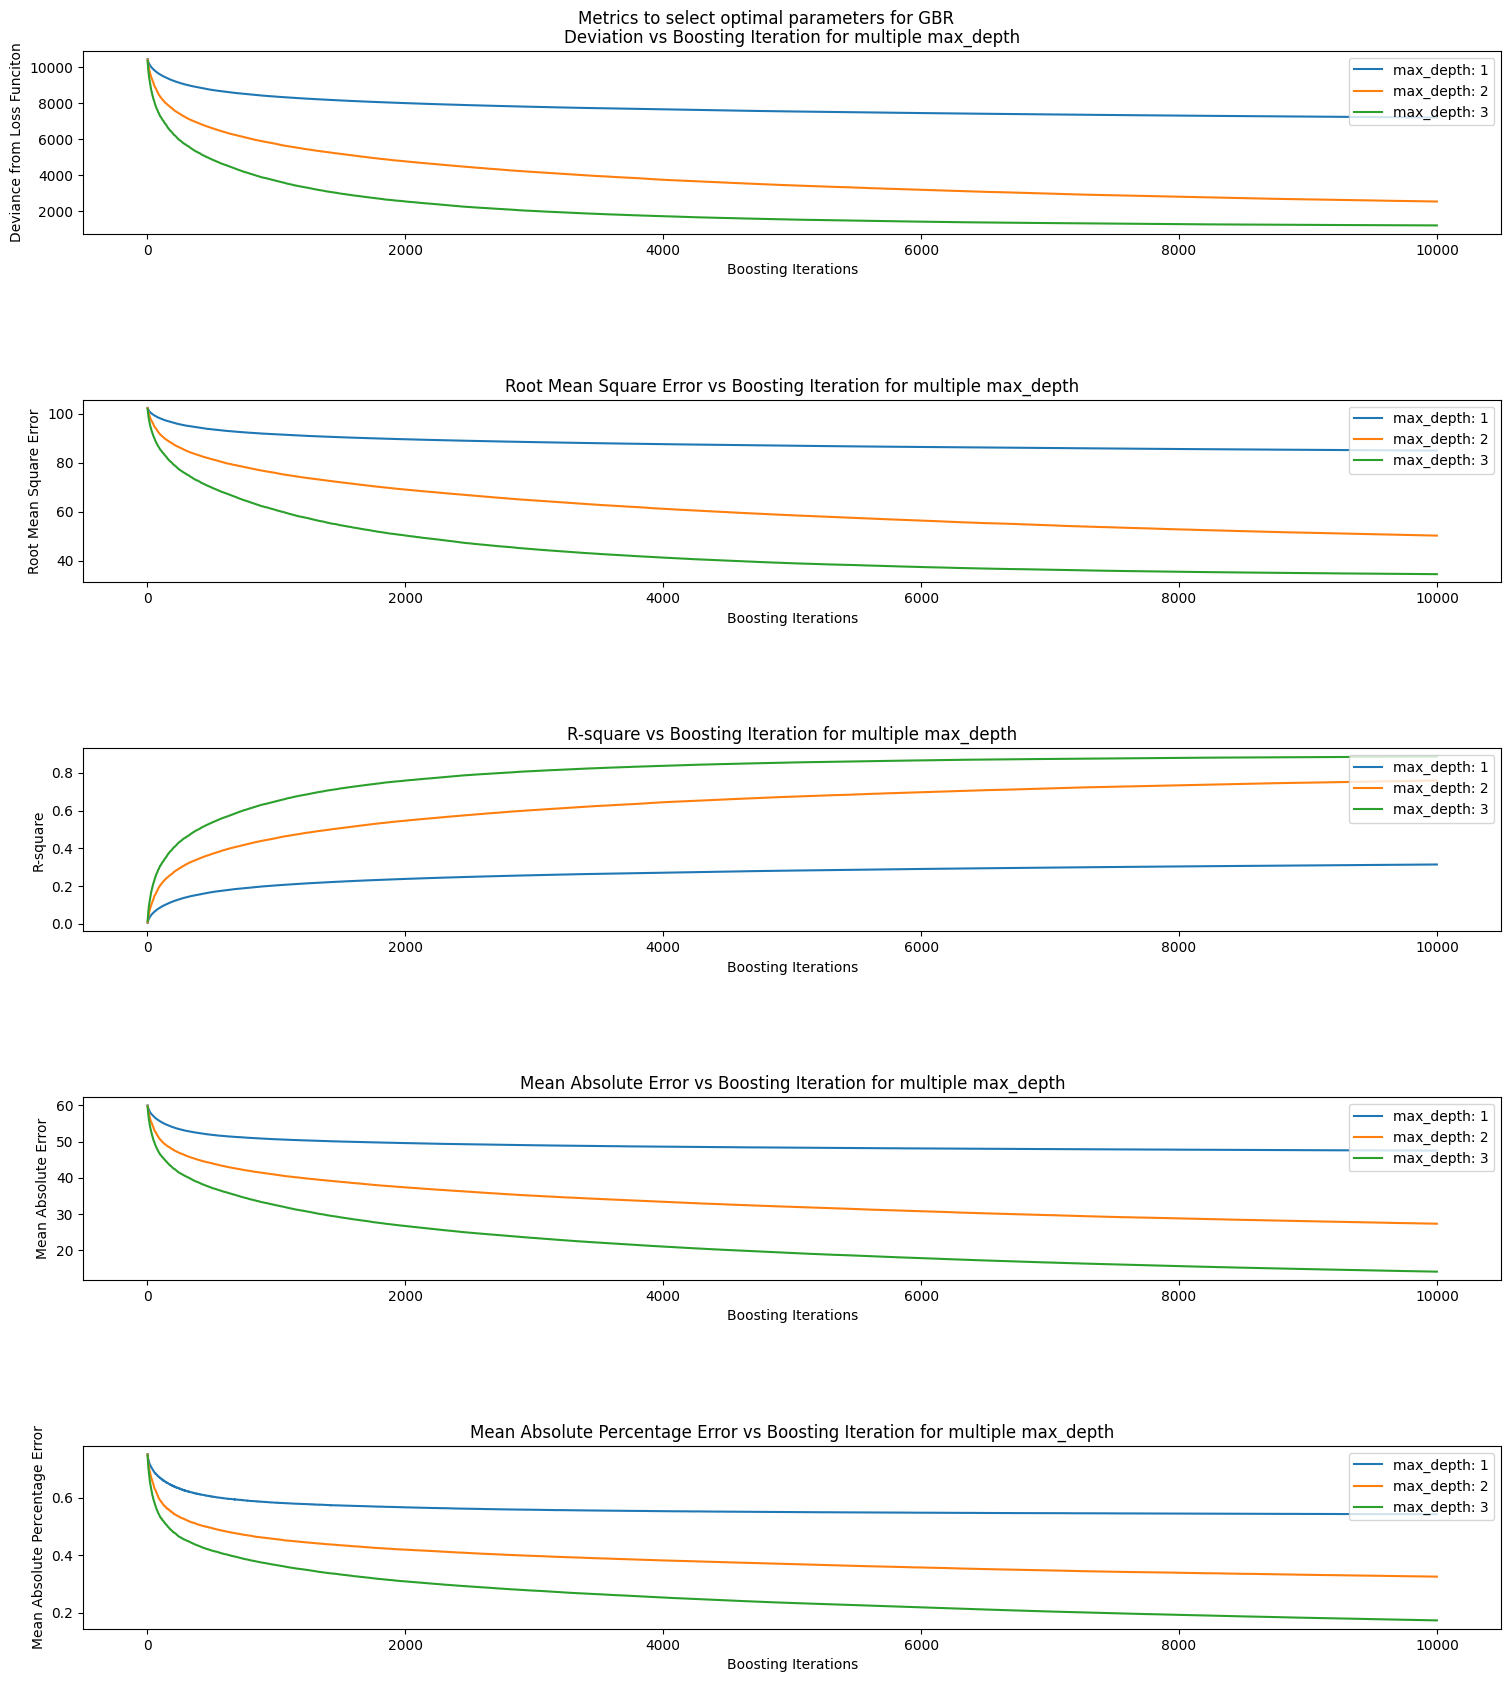

In [17]:
# Visualize model's metrics using line graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
gbr_metrics = pandas.read_csv(GBR_metrics_dataset_PATH.name)
figure, (plot1, plot2, plot3, plot4, plot5) = plot.subplots(5)
plot.tight_layout()

plot1.set_title("Deviation vs Boosting Iteration for multiple max_depth")
plot1.set_xlabel('Boosting Iterations')
plot1.set_ylabel('Deviance from Loss Funciton')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot1.plot(performance["iteration"], performance["training_loss"], label = "max_depth: "  + str(depth))
plot1.legend(loc='upper right')

plot2.set_title("Root Mean Square Error vs Boosting Iteration for multiple max_depth")
plot2.set_xlabel('Boosting Iterations')
plot2.set_ylabel('Root Mean Square Error')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot2.plot(performance["iteration"], performance["root_mean_square_error"], label = "max_depth: "  + str(depth))
plot2.legend(loc='upper right')

plot3.set_title("R-square vs Boosting Iteration for multiple max_depth")
plot3.set_xlabel('Boosting Iterations')
plot3.set_ylabel('R-square')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot3.plot(performance["iteration"], performance["r2_score"], label = "max_depth: "  + str(depth))
plot3.legend(loc='upper right')

plot4.set_title("Mean Absolute Error vs Boosting Iteration for multiple max_depth")
plot4.set_xlabel('Boosting Iterations')
plot4.set_ylabel('Mean Absolute Error')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot4.plot(performance["iteration"], performance["mean_absolute_error"], label = "max_depth: "  + str(depth))
plot4.legend(loc='upper right')

plot5.set_title("Mean Absolute Percentage Error vs Boosting Iteration for multiple max_depth")
plot5.set_xlabel('Boosting Iterations')
plot5.set_ylabel('Mean Absolute Percentage Error')
for depth in gbr_metrics["max_depth"].unique():
    performance = gbr_metrics.where(gbr_metrics["max_depth"] == depth).dropna()
    plot5.plot(performance["iteration"], performance["mean_absolute_percentage_error"], label = "max_depth: "  + str(depth))
plot5.legend(loc='upper right')

figure.set_figheight(18)
figure.set_figwidth(16)
figure.suptitle("Metrics to select optimal parameters for GBR")
figure.savefig("GBR_metrics_vs_iteration_for_multiple_max_depth.png")
figure.show()

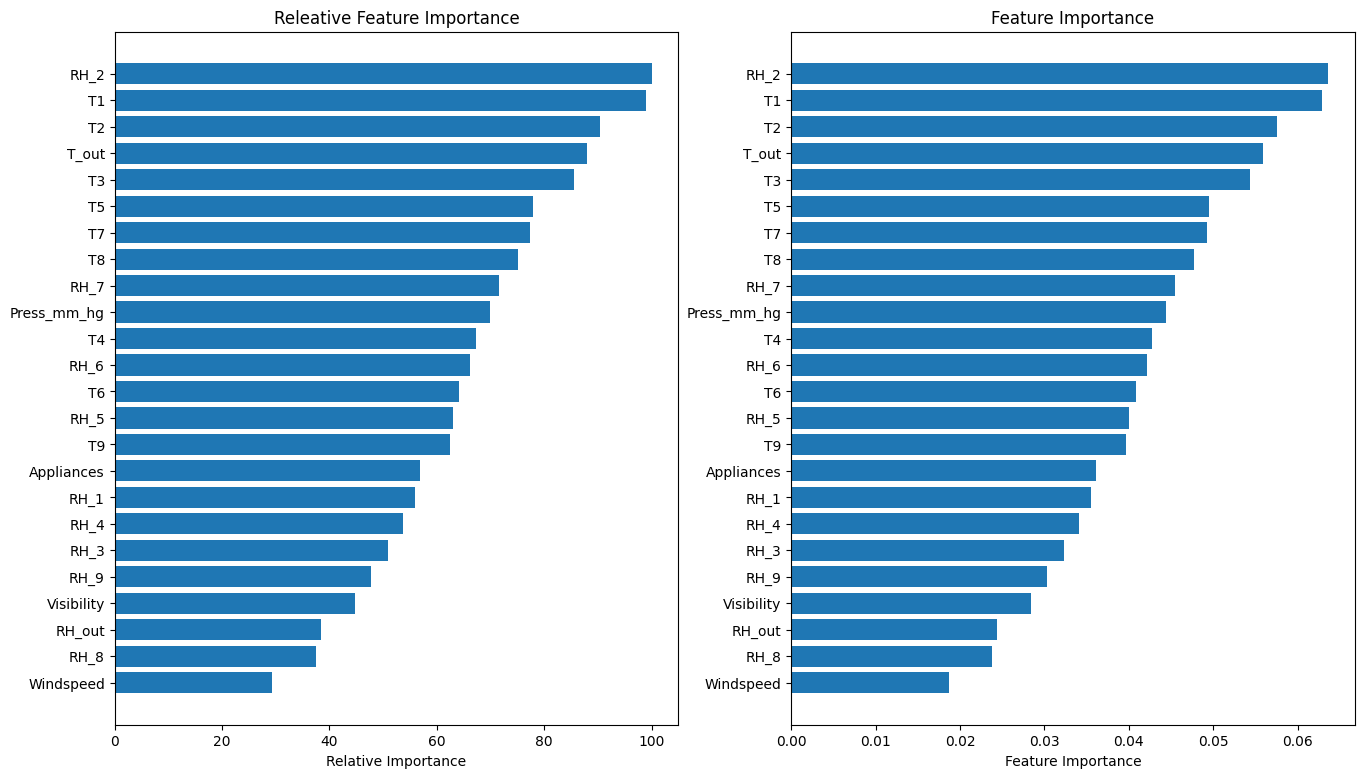

In [14]:
# Visualize feature importance of the model using bar graph subplots.
# Reference: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/subplots_demo.html
gbr_metrics = pandas.read_csv(GBR_RELEATIVE_FEATURE_IMPORTANCE_DATASET_PATH.name)

figure, (plot1, plot2) = plot.subplots(1, 2)

plot1.barh(gbr_metrics["feature_names"], gbr_metrics["releative_feature_importance"], align="center")
plot1.set_xlabel('Relative Importance')
plot1.set_title('Releative Feature Importance')

plot2.barh(gbr_metrics["feature_names"], gbr_metrics["feature_importance"], align="center")
plot2.set_xlabel('Feature Importance')
plot2.set_title('Feature Importance')

figure.set_figheight(9)
figure.set_figwidth(16)
figure.show()